# Example 3 - Parameter Exploration of Spectral Analysis method

Due to the deterministic approach that [Tanaka *et al.*, 1999](http://linkinghub.elsevier.com/retrieve/pii/S0040195199000724) uses for estimating $Z_b$, the uncertainties returned by `CurieGrid.tanaka1999` are the simple results of error propagation from the initial spectra uncertainties. The spectra uncertainties represent the variance within the sampled sector of the 2D FFT, and may comprise both noise and anisotropic signal.

We present here several tests of the `CurieGrid.tanaka1999` function in order to explore how the input parameters affect the resulting Curie point depth estimates. In particular, we consider the following:

1. Effect of where in $k$-space is specific window used, separately for both the power and $k$-weighted power spectra (i.e., which $k$ do we consider?).
2. Effect of $k$-space window size (i.e., how much of the $k$-domain do we consider?). It is important to note that increasing the $k$-bandwidth also stabilises the estimation by increasing the statistics of the spectrum portion.
3. Effect of magnetic data window size (i.e., domain of magnetic data before computing FFT).

### Contents

- [Varying spatial frequency range](#Varying-spatial-frequency-range)
- [Varying spatial frequency size](#Varying-spatial-frequency-size)
- [Varying window size of magnetic anomaly](#Varying-window-size-of-magnetic-anomaly)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

In [2]:
k_min0, k_max0 = 0.08, 0.18 # for zt
k_min1, k_max1 = 0.0, 0.03  # for zo
nx, ny = 343, 268      # nodes of grid;
window_size = 300e3    # windows size;
x_distance=25e3        # x moving distance, or x resolution
y_distance=25e3        # y moving distance, or x resolution
input_filename="../../data/mag-kirgging.dat"  # input data; a txt, inverse from grid;
output_filename="../../data/zb_3var.txt"   # result data 

In [3]:
# load x,y,anomaly
mag_data = np.loadtxt(input_filename)

x = mag_data[:,0]
y = mag_data[:,1]
# sometimes you need spesify a value when the spaceing is not idnetical.
nx=len(np.unique(x))   
ny=len(np.unique(y))
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

In [4]:
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)

# pick the centroid
xpt = 0.5*(xmin + xmax)
ypt = 0.5*(ymin + ymax)

window_size = 200e3
subgrid = grid.subgrid(window_size, xpt, ypt)
ypt = ymin + (ymax-ymin)/2

## Varying spatial frequency range

This test explores where in $k$-space is specific window used, separately for both the power and $k$-weighted power.

In [5]:

k, Phi, sigma_Phi = grid.radial_spectrum_log(subgrid, taper=None)

# Number of bins to divide k-range into
nbins = 10
hmap = np.zeros((nbins**2,3))

# k-range divided between 0 (i.e., DC), and 0.3 (i.e., spatial wavelengths of ~20 km)
kmin_range = np.linspace(0.0, 0.2, nbins)
kmax_range = kmin_range + 0.05

print(k.shape)

(49,)


In [6]:
for j in range(0,nbins):
    for l in range(0,nbins):
        k0 = kmin_range[j]
        k1 = kmax_range[j]
        k2 = kmin_range[l]
        k3 = kmax_range[l]
        (Ztr,btr,dZtr), (Zor, bor, dZor) = grid.optimise_tanaka(k, Phi,(k0, k1), (k2, k3))
        
        hmap[j*nbins+l,0] = (k0+k1)/2
        hmap[j*nbins+l,1] = (k2+k3)/2
        hmap[j*nbins+l,2] = 2*Zor-Ztr

Text(0.5,1,'Heatmap of CPD')

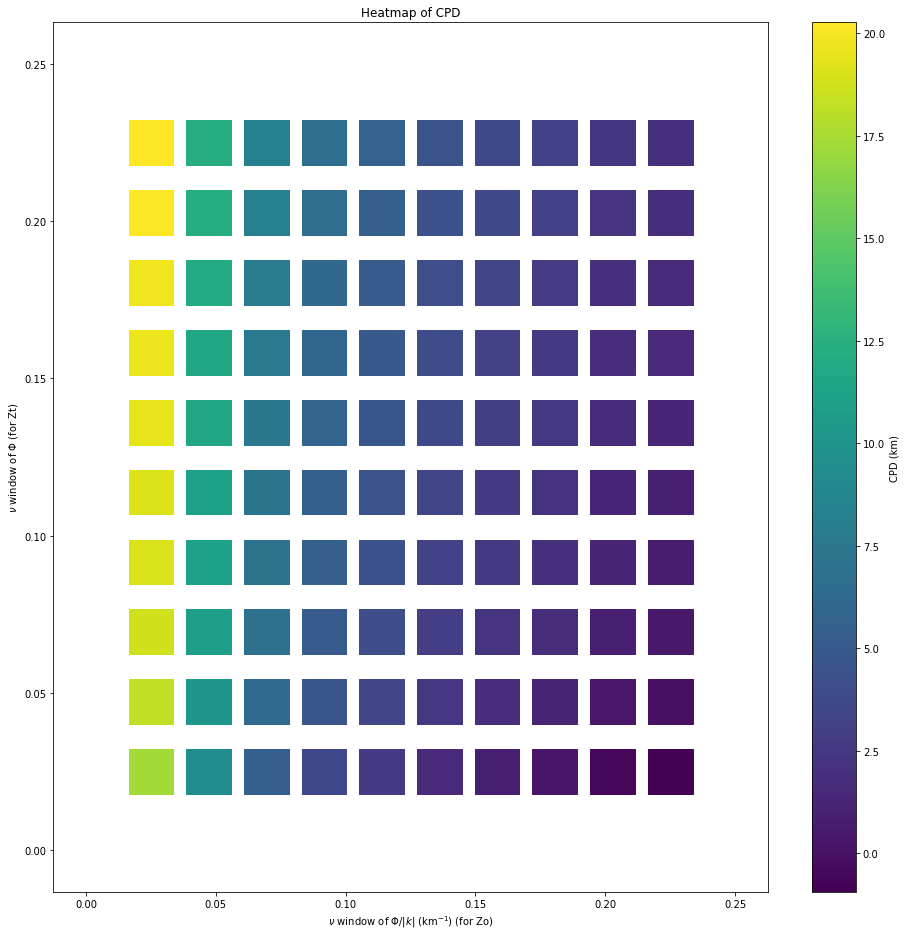

In [7]:
fig2 = plt.figure(figsize=(16,16))

ax2 = fig2.add_subplot(111)
ax2.set_xlabel(r'$\nu$ window of $\Phi/|k|$ (km$^{-1}$) (for Zo)')
ax2.set_ylabel(r'$\nu$ window of $\Phi$ (for Zt)')

# SCATTER PLOT
im2 = ax2.scatter(hmap[:,1], hmap[:,0], 2000, hmap[:,2], marker='s')
fig2.colorbar(im2, label='CPD (km)')
plt.title('Heatmap of CPD')

Results of this test suggest that the precise $k$ location of $Z_t$ is significantly less influential than the $k$ location of $Z_o$. Furthermore, for this test case with a known $Z_b$ of 16 km, a spatial frequency $\nu$ window of $0.125-0.2$ (i.e., $k\in\{0.8-1.25\}$ gives estimates consistent with the true $Z_b$. For simplicity, based upon this test we see minimal reason to not use the same $\nu/k$ window for each spectrum.

## Varying spatial frequency size

Explore the effect of $k$-space window size (i.e., how much of the $k$-domain do we consider?). Increasing the $k$-bandwidth also stabilises the estimation by increasing the statistics of the spectrum portion.

Text(0,0.5,'CPD depth (km)')

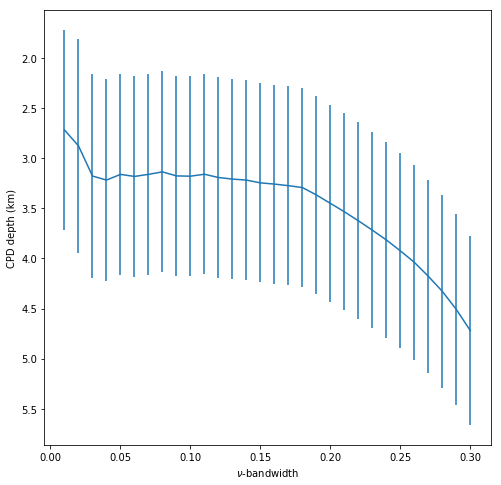

In [8]:
# 2) How big a bandwidth in k-space do we want?

k, Phi, sigma_Phi = grid.radial_spectrum_log(subgrid, taper=None)

# We are testing this by taking one central spatial frequency (k=1), and estimating Zb with increasing k-bandwidths.
# Recall k=2*pi*nu
nu = 1.0/(2.0*np.pi)

nbins = 30
output = np.zeros((nbins,3))
nr = np.linspace(0., 0.3, nbins+1)
output[:,0] = nr[1:]

for j in range(0,nbins,1):
    kmin = nu - 0.5*output[j,0]
    kmax = nu + 0.5*output[j,0]
    
    (Ztr,btr,dZtr), (Zor, bor, dZor) = grid.optimise_tanaka(k, Phi,(kmin, kmax), (kmin, kmax))
    Zb, eZb = pycurious.ComputeTanaka(Ztr, dZtr, Zor, dZor)
    output[j,1] = Zb
    output[j,2] = eZb
    
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111)
ax2.errorbar(output[:,0], output[:,1], yerr=output[:,2])
ax2.invert_yaxis()
ax2.set_xlabel('$\\nu$-bandwidth')
ax2.set_ylabel('CPD depth (km)')

The CPD estimates resulting from this test become consistent for $\nu$-bandwidths greater than approximately 0.1. Statistics improve with larger bandwidths, however, it is worth remaining aware of the typically non-linear trend of the spectrum, as it may not be appropriate for a linear fit over a large domain of $\nu$.

## Varying window size

Effect of magnetic data window size - i.e., domain of magnetic data before computing the FFT.

0.01230056307974577
0.011827464499755545
0.011182330072496154
0.01078996761381208
0.010250469233121475
0.009919808935278848
0.009461971599804437
0.00917952468637744
0.008786116485532694
0.008542057694267895
0.008200375386497179
0.00798737862321154
0.007687851924841106
0.007500343341308396
0.007235625341026922
0.007069289126290672
0.0068336461554143165
0.006685088630296613
0.006473980568287248
0.006340496432858645


Text(0,0.5,'CPD estimate (km)')

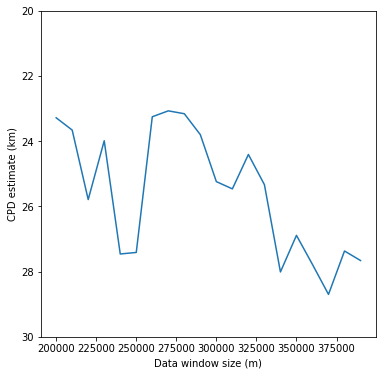

In [19]:
# 3) How large a window width of magnetic data is required?
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)
xpt = xmin + (xmax-xmin)/2
ypt = ymin + (ymax-ymin)/2

nwin = 20
baseW = 200e3
inc = 10e3

output = np.zeros((nwin,2))

# Define 'ws' as variable window size index
for i in range(0, nwin):
    ws = baseW + i*inc
    subgrid = grid.subgrid(ws, xpt, ypt)
    k, Phi, sigma_Phi = grid.radial_spectrum_log(subgrid, taper=None)
    k_min = k[1]/2/np.pi
    print( k_min)
    (Ztr,btr,dZtr), (Zor, bor, dZor) = grid.optimise_tanaka(k, Phi,  (0.08,0.18), (k_min,0.033))
    Zb = 2*Zor-Ztr
    
    output[i] = [ws, Zb]
    #print('Zb estimate for '+str(ws)+' m: '+np.array2string(Zb)+', +/- '+np.array2string(eZb)+' km')

fig, (ax1) = plt.subplots(1,1, figsize=(6,6),)
ax1.plot(output[:,0], output[:,1])
ax1.set_ylim(20,30)
ax1.invert_yaxis()
ax1.set_xlabel('Data window size (m)')
ax1.set_ylabel('CPD estimate (km)')


The results of this test highlight that there is a significant amount of variability in the CPD estimates at all window sizes, inferring that where possible, a range of window sizes should be tested for any data set. However, the righthand plot of propagated error in the CPD estimates clarifies that estimates from larger windows are more robust. In particular, with the prior knowledge that the CPD of the test data is 16 km, window sizes of greater than 80 km show a reduced improvement in statistics. 